In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

RDKit WARNING: [13:48:20] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
config = process_config('experiments/2020-03-24/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/2020-03-24/LSTM_Chem/model_arch.json ...


100%|██████████| 5/5 [00:00<00:00, 8680.26it/s]

Loading model checkpoint from experiments/2020-03-24/LSTM_Chem/checkpoints/LSTM_Chem-22-0.45.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...
done.
Train for 5 steps
Epoch 1/12


5/5 [==============================] - 3s 613ms/step - loss: 1.0130
Epoch 2/12
5/5 [==============================] - 1s 190ms/step - loss: 0.7937
Epoch 3/12
5/5 [==============================] - 1s 217ms/step - loss: 0.7656
Epoch 4/12
5/5 [==============================] - 1s 192ms/step - loss: 0.7769
Epoch 5/12
5/5 [==============================] - 1s 231ms/step - loss: 0.6699
Epoch 6/12


5/5 [==============================] - 1s 176ms/step - loss: 0.9115
Epoch 7/12
5/5 [==============================] - 1s 254ms/step - loss: 0.6257
Epoch 8/12
5/5 [==============================] - 1s 232ms/step - loss: 0.5616
Epoch 9/12
5/5 [==============================] - 1s 234ms/step - loss: 0.5275
Epoch 10/12
3/5 [=================>............] - ETA: 0s - loss: 0.2925WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


5/5 [==============================] - 1s 236ms/step - loss: 0.4256
Epoch 11/12
5/5 [==============================] - 1s 224ms/step - loss: 0.5061
Epoch 12/12
5/5 [==============================] - 1s 212ms/step - loss: 0.2708


In [3]:
finetuned_smiles = finetuner.sample(num=100)

In [4]:
with open('./datasets/known_TRPM8-inhibitors_cleansed.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [5]:
with open('./datasets/TRPM8_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [6]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [7]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

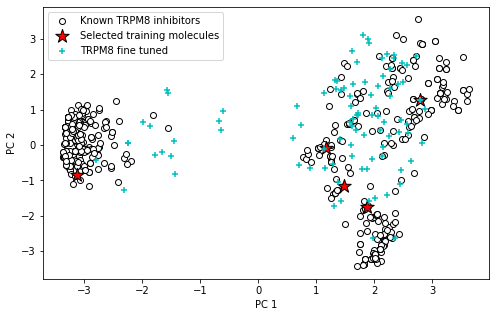

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 fine tuned')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [9]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [10]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

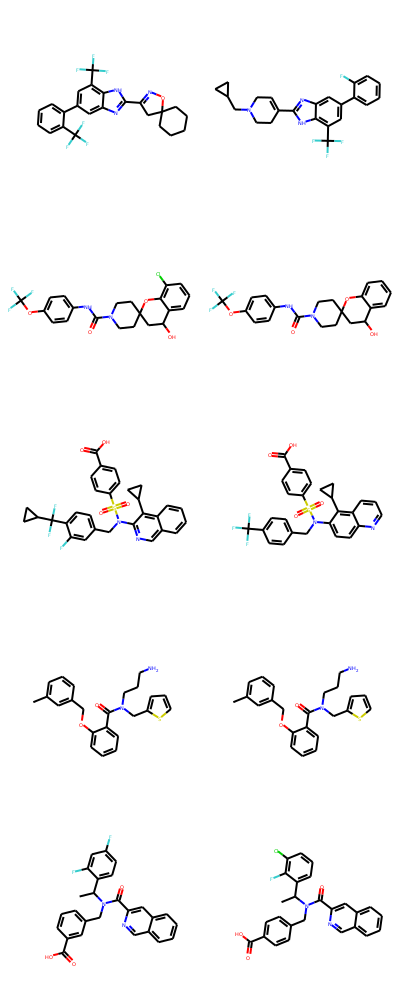

In [11]:
Draw.MolsToGridImage(showmols, molsPerRow=2)